# Method 1 - Least Squares Regression

Statistical evaluation of failure stresses. 

The process is as follows:
- Calculate the stress at failure for each specimen and sort them in increasing order of magnitude: $ \sigma_i $, where $ i $ is the rank number.
- Calculate the probability of failure $ P_{f,i} $ for each measured value. Use the following estimator:
$
  P_{f,i} = \frac{i}{n+1}
$
  where $ n $ is the number of tested samples.
- Put the Weibull distribution into linearized form. Enter the measured data into the Weibull mesh.
- Fit the data by linear regression. Find the slope, the intercept, and the coefficient of determination $ R^2 $.
- Determine the Weibull parameters $ \lambda $ (shape parameter) and $ \beta $ (scale parameter).
- Calculate the confidence interval $ C $ and plot it on the Weibull mesh.
- Determine the 5% fractile value of the bending tensile strength $ f_y $ using the regression line and using the confidence interval. In the case of the confidence interval, use the target goal seek.
- Plot the cumulative distribution function $ F(x) $ and the density function $ f(x) $.

In [134]:
import numpy as np
import pandas as pd
from scipy.stats import linregress, t
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from scipy.optimize import fsolve
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
%config InlineBackend.figure_format = 'svg'

### Definition of useful functions 


In [135]:
def steyx(x, y):
    n = len(x)
    if len(y) != n:
        raise ValueError("x and y must have the same length")
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the slope and intercept
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    intercept = y_mean - slope * x_mean

    # Calculate predicted y-values
    y_pred = slope * x + intercept

    # Calculate standard error
    se = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    return se

# Define confidence function
def CI(x):
    return t_value * se * np.sqrt(1/n + (x - mean_ln_stress)**2 / np.sum((ln_stress - mean_ln_stress)**2))

# Define the function of the upper confidence interval
def f_upper(x):
    return slope*x + intercept - CI(x) 

# Define the function of the lower confidence interval
def f_lower(x):
    return slope*x + intercept + CI(x) 

# Define a function that subtracts the target value
def goal_seek_function_CI_upper(x):
    return f_upper(x) - target_value

# Define a function that subtracts the target value
def goal_seek_function_CI_lower(x):
    return f_lower(x) - target_value

# Weibull PDF
def weibull_pdf(x, beta, lambda_):
    return (lambda_ / beta) * (x / beta)**(lambda_ - 1) * np.exp(-(x / beta)**lambda_)

# Weibull CDF
def weibull_cdf(x, beta, lambda_):
    return 1 - np.exp(-(x / beta)**lambda_)

### Input the failure stress rates from experimental data.
1. Select the desired stress fractile and confidence interval.

In [136]:
{
    "tags": [
        "hide-input",
    ]
}

# Create an HTML widget for instructions
instructions = widgets.HTML(
    value="""
    <p style="font-size: 16px">Enter the data separated by commas, with decimal point (e.g. "1.44, 2.33, 4.22, 3.01,...")</p>
    <b style="font-size: 16px">Data protection declaration: The data entered will not be saved or transmitted over the network.</b>
    """
)

blank_space = widgets.HTML(
    value="""<br>"""
)


# Widget to ask user how many datasets they want
num_datasets_input = widgets.IntText(
    value=3,  # Default value
    description="Number of Datasets:",
    style={'description_width': 'auto'},
    layout=widgets.Layout(width='250px')
)

# Button to confirm number of datasets
confirm_button = widgets.Button(description="Confirm")

# Container to hold dataset input fields dynamically
dataset_container = widgets.VBox()

# Container for target values
target_inputs = widgets.VBox()

# # Toggle button for confidence interval display (Boolean)
# confidence_toggle = widgets.ToggleButton(
#     value=False,  # Default: Show Confidence Intervals
#     description="Show Confidence",
#     tooltip="Click to toggle confidence interval display"
# )


# Button to evaluate inputs
evaluate_button = widgets.Button(description="Evaluate", disabled=True)

# Output container for display
output = widgets.Output()

# Variables to hold dynamic widgets
dataset_name_inputs = []  # List to hold dataset name input widgets
dataset_value_inputs = []  # List to hold dataset text input widgets

# Function to generate input fields dynamically
def generate_inputs(event):
    global dataset_name_inputs, dataset_value_inputs
    
    num_datasets = num_datasets_input.value
    dataset_name_inputs = []
    dataset_value_inputs = []

    # Lists to arrange input areas
    dataset_layout = []
    
    for i in range(num_datasets):
        
        # Dataset Name Input
        dataset_name = widgets.Text(
            description=f"Name {i+1}:",
            placeholder=f"Dataset {i+1}",
            layout=widgets.Layout(width="250px"),
            style={'description_width': 'auto'}
        )
        dataset_name_inputs.append(dataset_name)
        
        # Create dataset input field (values)
        dataset_text = widgets.Textarea(
            description=f"Values {i+1}:",
            placeholder="Enter values separated by commas...",
            layout=widgets.Layout(width="500px", height="50px"),
            style={'description_width': 'auto'}
        )
        dataset_value_inputs.append(dataset_text)
        

        # Add the widgets to the layout
        dataset_layout.append(widgets.HBox([dataset_name, dataset_text]))

    # Create input fields for Target Stress Fractile and Confidence Interval
    target_g_text = widgets.FloatText(
        description="Target stress fractile:",
        value=0.05, layout=widgets.Layout(width="300px"),
        style={'description_width': 'auto'}
    )
    
    target_alpha_text = widgets.FloatText(
        description="Target confidence interval:",
        value=0.05, layout=widgets.Layout(width="300px"),
        style={'description_width': 'auto'}
    )

    # Update the target inputs container
    target_inputs.children = [target_g_text, target_alpha_text]

    # Update the dataset container with new input fields
    dataset_container.children = dataset_layout

    # Enable the evaluate button
    evaluate_button.disabled = False

# Attach event to confirm button
confirm_button.on_click(generate_inputs)

# Function to evaluate inputs
def evaluate(event):
    with output:
        clear_output()
        global stress_rates,target_P_f,target_alpha
        stress_rates = {}


        try:
            # # Get user's choice from the toggle button
            # show_confidence_intervals = confidence_toggle.value  
            # Extract dataset values
            for i in range(len(dataset_value_inputs)):
                dataset_name = dataset_name_inputs[i].value.strip() or f"Dataset {i+1}"
                data_values = [float(x.strip()) for x in dataset_value_inputs[i].value.split(",") if x.strip()]
                
                stress_rates[dataset_name] = np.array(data_values)
            # Extract target values
            target_P_f = float(target_inputs.children[0].value)
            target_alpha = float(target_inputs.children[1].value)
            
            # Display results
            for dataset_name in stress_rates.keys():
                print(f"{dataset_name}; n = {len(stress_rates[dataset_name])} samples: {stress_rates[dataset_name]}")
            
            print(f"\nTarget stress fractile: {target_P_f * 100}%")
            print(f"Target confidence interval: {int((1 - target_alpha) * 100)}%")

            # # Show confidence interval only if the toggle is ON
            # if show_confidence_intervals:
            #     display_confidence_intervals_ON = True # Turn the confidence intervals ON in the Logarithmic CDF Weibull Plot
            #     print(f"Target confidence interval display: ON")
            # else:
            #     display_confidence_intervals_ON = False # Turn the confidence intervals OFF in the Logarithmic CDF Weibull Plot
            #     print(f"Target confidence interval display: OFF")

        except ValueError:
            print("Error: Please enter valid comma-separated numbers.")

# Attach event to evaluate button
evaluate_button.on_click(evaluate)

# Arrange and display widgets
display(instructions,widgets.VBox([num_datasets_input, confirm_button, dataset_container, target_inputs, evaluate_button, output]))

HTML(value='\n    <p style="font-size: 16px">Enter the data separated by commas, with decimal point (e.g. "1.4…

### Start of Statistical evaluation

Fractile [%],Stress [MPa],95% CI lower [MPa],95% CI upper [MPa]
0.8%,33.96,28.91,37.97
5%,45.76,41.59,48.94
50%,69.53,67.56,71.69
Selected 5.0%,45.76,41.59,48.94


Min Stress [MPa],Max Stress [MPa],Mean Stress [MPa],Coeff. of variation [%]
53.14,87.54,68.77,16.08


Fractile [%],Stress [MPa],95% CI lower [MPa],95% CI upper [MPa]
0.8%,36.61,35.78,37.33
5%,41.06,40.51,41.55
50%,48.25,48.0,48.5
Selected 5.0%,41.06,40.51,41.55


Min Stress [MPa],Max Stress [MPa],Mean Stress [MPa],Coeff. of variation [%]
41.26,53.17,47.87,6.69


Fractile [%],Stress [MPa],95% CI lower [MPa],95% CI upper [MPa]
0.8%,56.13,50.96,60.96
5%,89.4,84.37,93.99
50%,171.9,168.15,175.84
Selected 5.0%,89.4,84.37,93.99


Min Stress [MPa],Max Stress [MPa],Mean Stress [MPa],Coeff. of variation [%]
84.1,253.6,170.49,24.87


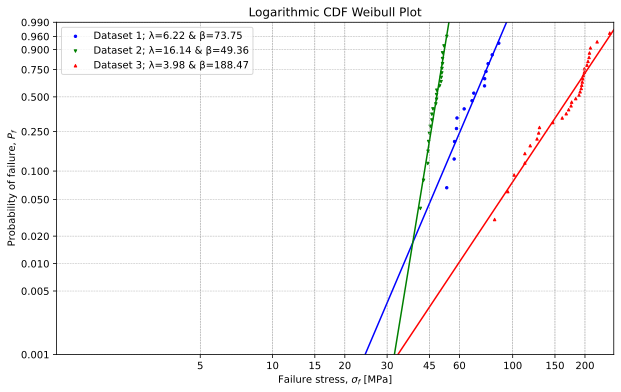

In [137]:
plt.figure(figsize=(10, 6))
i = 0; 
min_stress_rate = 100000
max_stress_rate = -10000

# Initialize an empty dictionary to store the scale & shape value of a Weibull distribution corresponding to each dataset.
Weibull_distribution_parameters = {}
Regression_line_parameters = {}
for dataset, stress_rate in stress_rates.items():
    
    if stress_rate.size > 0 and np.any(stress_rate != 0):
        # Sort the stress in increasing order
        sorted_stress = np.sort(stress_rate)
    
        # Calculate probability of failure (P_f,i)
        n = len(sorted_stress)
    
        P_f = np.array([(i) / (n+1) for i in range(1,n+1)])
        # Linearize the Weibull distribution
        ln_stress = np.log(sorted_stress)
    
        ln_ln_Pf = np.log(np.log(1 / (1 - P_f)))
    
        # Perform linear regression
        slope, intercept, r_value, p_value, std_error = linregress(ln_stress, ln_ln_Pf)
        R_squared = r_value**2
        std_err = steyx(ln_stress, ln_ln_Pf)
    
        # Calculate the standard error
        se = std_err
    
        # Calculate the t-value for 95% confidence
        alpha = target_alpha
        t_value = t.ppf(1 - alpha/2, df=n-2)
    
        # Calculate the confidence interval
        mean_ln_stress = np.mean(ln_stress)
    
        C = t_value * se * np.sqrt(1/n + (ln_stress - mean_ln_stress)**2 / np.sum((ln_stress - mean_ln_stress)**2))
        
        # Weibull Parameters estimation
        shape = slope                    # lambda
        scale = np.exp(-intercept/slope) # beta
        Weibull_distribution_parameters[dataset] = (scale,shape)
        Regression_line_parameters[dataset] = (slope, intercept, R_squared)
    
    
        # Plot with confidence interval
        # List of marker symbols to cycle through
        # Uncomment more symbols for larger number of datasets
        markers = [
            #'.',  # Point
            #',',  # Pixel
            'o',  # Circle
            'v',  # Triangle down
            '^',  # Triangle up
            #'<',  # Triangle left
            #'>',  # Triangle right
            #'1',  # Tri-down
            #'2',  # Tri-up
            #'3',  # Tri-left
            #'4',  # Tri-right
            's',  # Square
            #'p',  # Pentagon
            #'*',  # Star
            #'h',  # Hexagon 1
            #'H',  # Hexagon 2
            #'+',  # Plus
            #'x',  # X
            'D',  # Diamond
            #'d',  # Thin diamond
            #'|',  # Vertical line
            #'_',  # Horizontal line
        ]
        # List of line styles to cycle through
        line_styles = [
            '-',    # Solid line
            '--',   # Dashed line
            '-.',   # Dash-dot line
            ':',    # Dotted line
            # Uncomment more styles for larger number of datasets
            # '',     # No line
        ]
    
        # List of colors to cycle through
        colors = [
            'b',    # Blue
            'g',    # Green
            'r',    # Red
            'c',    # Cyan
            'm',    # Magenta
            'y',    # Yellow
            'k',    # Black
            # Uncomment more colors for larger number of datasets
            # 'w',   # White
            # '#1f77b4', # Light blue
            # '#ff7f0e', # Orange
            # '#2ca02c', # Light green
            # '#d62728', # Light red
            # '#9467bd', # Purple
        ]
        # Select marker symbol from the list
        marker = markers[i % len(markers)]
        # Select line style and color from the lists
        line_style = line_styles[i % len(line_styles)]
        color = colors[i % len(colors)]
        
        # Creating a range of x values
        
        if min(stress_rate) < min_stress_rate:
            min_stress_rate = min(stress_rate)
        if max(stress_rate) > max_stress_rate:
            max_stress_rate = max(stress_rate)
    
        # Equation of the line in the form y = mx + c
        # Use y1 = m * x1 + c to find c
        x = np.linspace(min_stress_rate-30,max_stress_rate+30,1000)
        y = weibull_cdf(x, scale, shape)
        #fitted_line = np.log(np.log(1 / (1 - (slope * x + intercept)))) 
        #slope, intercept, r_value, p_value, std_error = linregress(np.log(stress_rate), np.log(P_f))
        # if display_confidence_intervals_ON:
        #     plt.fill_between(sorted_stress, slope * sorted_stress + intercept - C, slope * sorted_stress + intercept + C, color='grey', alpha=0.3, label=f'{int((1-target_alpha/2)*100)}% Confidence interval')
        plt.scatter(sorted_stress, P_f, color= color, s=6, label=f'{dataset}; \u03BB={shape:.2f} & \u03B2={scale:.2f}',marker = marker)
        plt.plot(x, y, color=color)
    
        # Determine the x% fractile
        Pf_x = target_P_f
        ln_ln_Pf_5 = np.log(np.log(1 / (1 - Pf_x)))
        x_5 = (ln_ln_Pf_5 - intercept) / slope  
        stress_x_percentile = round(np.exp(x_5),2)
    
        # Set the target value
        # Determine the x% fractile
        target_value = np.log(np.log(1 / (1 - Pf_x)))
    
        # Initial guess
        initial_guess = 3.0
    
        # Use fsolve to perform the goal seek for the upper value of the confidence interval
        solution_CI_upper = fsolve(goal_seek_function_CI_upper, initial_guess)
        # Use fsolve to perform the goal seek for the lower value of the confidence interval
        solution_CI_lower = fsolve(goal_seek_function_CI_lower, initial_guess)
    
        # Output the solution
        #print(f"The value of x that makes P_f(x) = {target_value} is: {solution_CI_upper[0]}")
        #print(f"The value of x that makes P_f(x) = {target_value} is: {solution_CI_lower[0]}")
        stress_x_percentile_CI_upper = round(np.exp(solution_CI_upper[0]),2)
        stress_x_percentile_CI_lower = round(np.exp(solution_CI_lower[0]),2)
    
        # print(f"Selected {target_P_f*100}% Fractile Stress: {stress_x_percentile:.2f} MPa")
        # print(f"Selected {int((1-target_alpha/2)*100)}% Confidence Interval of {target_P_f*100}% Fractile: ({stress_x_percentile_CI_lower:.2f}, {stress_x_percentile_CI_upper:.2f}) MPa")
        # Add regression equation and R-squared below the figure
        # regression_text = f"y = {slope:.2f}x {'+' if intercept > 0 else '-'} {abs(intercept):.2f}; $R^2$ = {r_value**2:.3f}"
        # stress_text = f"{target_P_f*100}%  Fractile Stress: {stress_x_percentile:.2f} MPa\n" \
        #               f"{int((1-target_alpha/2)*100)}% Confidence Interval of {target_P_f*100}% Fractile: ({stress_x_percentile_CI_lower:.2f}, {stress_x_percentile_CI_upper:.2f}) MPa"
        # plt.figtext(0.5, -0.08 - i * 0.11,
        #     f"Regression line for {dataset}: {regression_text}\n {stress_text}",
        #     wrap=True, horizontalalignment='center', fontsize=10,
        #     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
        i += 1
    
        # Determine the 0.8% fractile
        Pf_08 = 0.008
        ln_ln_Pf_08 = np.log(np.log(1 / (1 - Pf_08)))
        x_08 = (ln_ln_Pf_08 - intercept) / slope  
        stress_08_percentile = round(np.exp(x_08),2)
        target_value = np.log(np.log(1 / (1 - Pf_08)))
    
        # Initial guess
        initial_guess = 3.0
    
        # Use fsolve to perform the goal seek for the upper value of the confidence interval
        solution_CI_upper = fsolve(goal_seek_function_CI_upper, initial_guess)
        # Use fsolve to perform the goal seek for the lower value of the confidence interval
        solution_CI_lower = fsolve(goal_seek_function_CI_lower, initial_guess)
    
        stress_08_percentile_CI_upper = round(np.exp(solution_CI_upper[0]),2)
        stress_08_percentile_CI_lower = round(np.exp(solution_CI_lower[0]),2)
    
    
        # Determine the 5% fractile
        Pf_5 = 0.05
        ln_ln_Pf_5 = np.log(np.log(1 / (1 - Pf_5)))
        x_5 = (ln_ln_Pf_5 - intercept) / slope  
        stress_5_percentile = round(np.exp(x_5),2)
        target_value = np.log(np.log(1 / (1 - Pf_5)))
    
        # Initial guess
        initial_guess = 3.0
    
        # Use fsolve to perform the goal seek for the upper value of the confidence interval
        solution_CI_upper = fsolve(goal_seek_function_CI_upper, initial_guess)
        # Use fsolve to perform the goal seek for the lower value of the confidence interval
        solution_CI_lower = fsolve(goal_seek_function_CI_lower, initial_guess)
    
        stress_5_percentile_CI_upper = round(np.exp(solution_CI_upper[0]),2)
        stress_5_percentile_CI_lower = round(np.exp(solution_CI_lower[0]),2)
        # Determine the 50% fractile
        Pf_50 = 0.5
        ln_ln_Pf_50 = np.log(np.log(1 / (1 - Pf_50)))
        x_50 = (ln_ln_Pf_50 - intercept) / slope  
        stress_50_percentile = round(np.exp(x_50),2)
        target_value = np.log(np.log(1 / (1 - Pf_50)))
    
        # Initial guess
        initial_guess = 3.0
    
        # Use fsolve to perform the goal seek for the upper value of the confidence interval
        solution_CI_upper = fsolve(goal_seek_function_CI_upper, initial_guess)
        # Use fsolve to perform the goal seek for the lower value of the confidence interval
        solution_CI_lower = fsolve(goal_seek_function_CI_lower, initial_guess)
    
        stress_50_percentile_CI_upper = round(np.exp(solution_CI_upper[0]),2)
        stress_50_percentile_CI_lower = round(np.exp(solution_CI_lower[0]),2)

        # Calculate the mean of the data
        mean = np.mean(stress_rate)
    
        # Calculate the standard deviation of the data for a sample
        std_dev = np.std(stress_rate, ddof=1)  # Use ddof=1 for sample standard deviation or ddof=0  for population standard deviation
    
        # Calculate the coefficient of variation
        coefficient_of_variation = (std_dev / mean) * 100
    
        # Define the data for the table containing integers
        table_data1 = [
            ("Fractile [%]", "Stress [MPa]", "95% CI lower [MPa]", "95% CI upper [MPa]"),
            ("0.8%", stress_08_percentile, stress_08_percentile_CI_lower, stress_08_percentile_CI_upper),                     # Row 1 
            ("5%", stress_5_percentile,stress_5_percentile_CI_lower,stress_5_percentile_CI_upper),                            # Row 2 
            ("50%", stress_50_percentile,stress_50_percentile_CI_lower,stress_50_percentile_CI_upper),                        # Row 3 
            (f"Selected {target_P_f*100}%", stress_x_percentile,stress_x_percentile_CI_lower,stress_x_percentile_CI_upper)    # Row 4 
        ]
    
        # Generate HTML for the table
        html_content1 = f"""
        <table border='1' style='border-collapse: collapse;'>
            <caption style='caption-side: top; font-weight: bold;'>{dataset} (n={n})</caption>
        """
        for row in table_data1:
            html_content1 += "<tr>"
            for item in row:
                html_content1 += f"<td style='padding: 5px;'>{item}</td>"
            html_content1 += "</tr>"
        html_content1 += "</table>"
    
         # Define the data for the table containing integers
        table_data2 = [
            ("Min Stress [MPa]", "Max Stress [MPa]", " Mean Stress [MPa]", "Coeff. of variation [%]"),
            (round(min(sorted_stress),2), round(max(sorted_stress),2), round(np.mean(sorted_stress),2), round(coefficient_of_variation,2)),
        ]
    
        # Generate HTML for the table
        html_content2 = f"""
        <table border='1' style='border-collapse: collapse;'>
            <caption style='caption-side: top; font-weight: bold;'>{dataset} (n={n})</caption>
        """
        for row in table_data2:
            html_content2 += "<tr>"
            for item in row:
                html_content2 += f"<td style='padding: 5px;'>{item}</td>"
            html_content2 += "</tr>"
        html_content2 += "</table>"
    
        # Add regression equation and R-squared below table 2
        slope = Regression_line_parameters[dataset][0]
        intercept = Regression_line_parameters[dataset][1]
        R_squared = Regression_line_parameters[dataset][2]
        html_content3 = f"""
        <p>Regression line for "<strong>{dataset}</strong>" (<strong>n={n}</strong>) is: <strong>y = {slope:.2f}x {'+' if intercept > 0 else '-'} {abs(intercept):.2f}; R<sup>2</sup>= {R_squared:.3f}</strong></p>
        """
    
        # Display the table using HTML
        display(HTML(html_content1),HTML(html_content2),HTML(html_content3))
    
plt.xlabel(f'Failure stress, $\u03C3_f$ [MPa]')
plt.ylabel('Probability of failure, $P_f$')
plt.title('Logarithmic CDF Weibull Plot')

probs = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.96, 0.99]
# Draw vertical lines
xticks = [ 5, 10, 15, 20, 30, 45, 60, 100, 150, 200]
vertical_lines = xticks
for x in vertical_lines:
    plt.axvline(x=x, color='grey', alpha = 0.5, linestyle='--', linewidth=0.5)

# Set custom y-ticks and log scale
SMALL = 1.0e-20    # attempt to protect against invalid arguments to log
def forwardY( p ):
    return np.log(np.fmax(SMALL, -np.log(np.fmax(SMALL,1-p))))

def inverseY( q ):
    return 1 - np.exp(-np.exp(q))

def forwardX(x):
    return np.log(np.fmax(SMALL,x))

def inverseX(y):
    return np.exp(y)
plt.xlim(left=min_stress_rate, right=max_stress_rate)
plt.ylim(bottom=0.001, top=0.99)
plt.xscale('function', functions=(forwardX,inverseX))
plt.yscale('function', functions=(forwardY,inverseY))
plt.yticks(probs)
# Set x-ticks and their visible labels
plt.xticks(vertical_lines, [str(v) for v in vertical_lines])
plt.xlim(min_stress_rate - 40, max_stress_rate + 10)
# Get handles and labels, then filter to make them unique
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels_set = set()
unique_handles_labels = []

for handle, label in zip(handles, labels):
    if label not in unique_labels_set:
        unique_handles_labels.append((handle, label))
        unique_labels_set.add(label)

# Construct separate lists for handles and labels, and position the legend
if unique_handles_labels:
    unique_handles, unique_labels = zip(*unique_handles_labels)
    plt.legend(unique_handles, unique_labels, loc='upper left')
#plt.grid(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


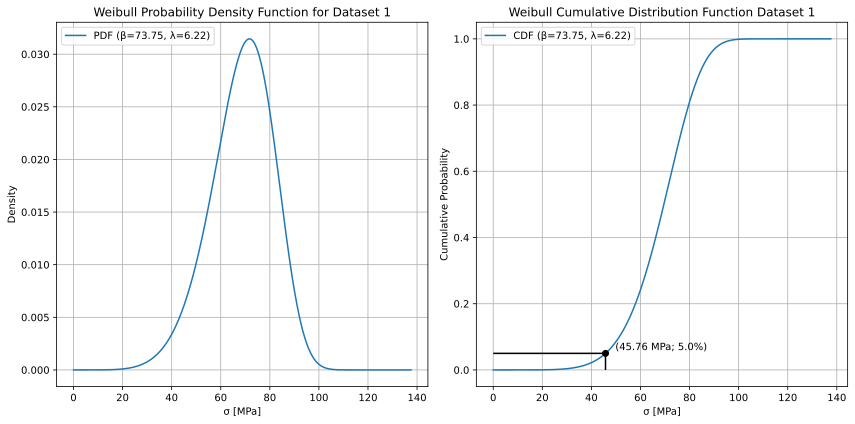

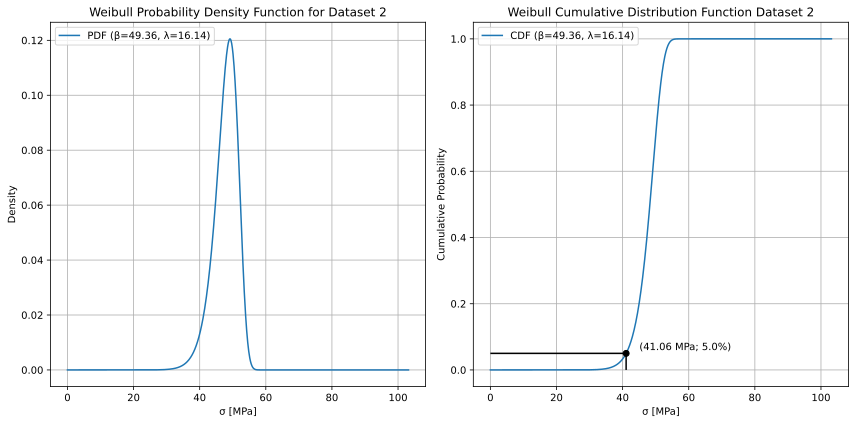

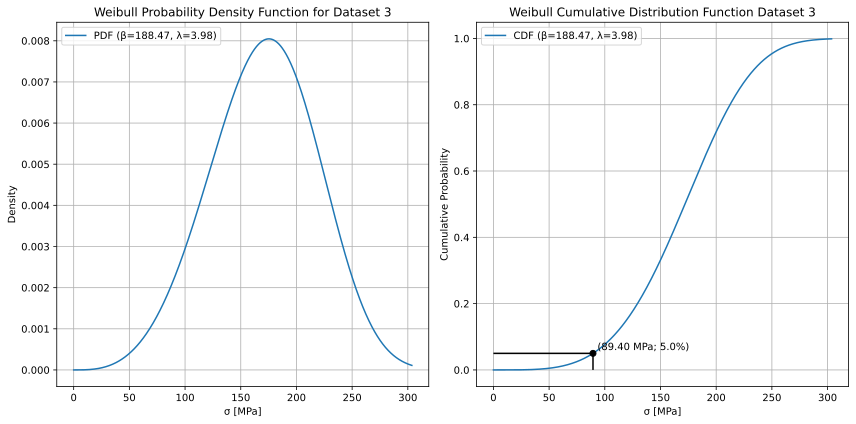

In [138]:

for dataset, stress_rate in stress_rates.items():
    if stress_rate.size > 0 and np.any(stress_rate != 0):
        # Creating a range of x values
        x = np.linspace(0,max(stress_rate)+50,1000)
        # Calculate PDF and CDF
        pdf_values = weibull_pdf(x, Weibull_distribution_parameters[dataset][0], Weibull_distribution_parameters[dataset][1])
        cdf_values = weibull_cdf(x, Weibull_distribution_parameters[dataset][0], Weibull_distribution_parameters[dataset][1])
        # Calculate the x% fractile
        target_percentile = 1 - target_P_f
        x_percentile = Weibull_distribution_parameters[dataset][0] * (-np.log(target_percentile))**(1/Weibull_distribution_parameters[dataset][1])
        # Plotting
        plt.figure(figsize=(12, 6))
        # Plot PDF
        plt.subplot(1, 2, 1)
        plt.plot(x, pdf_values, label=f"PDF (\u03B2={Weibull_distribution_parameters[dataset][0]:.2f}, \u03BB={Weibull_distribution_parameters[dataset][1]:.2f})")
        plt.title(f'Weibull Probability Density Function for {dataset}')
        plt.xlabel('\u03C3 [MPa]')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend(loc='upper left')
        # Plot CDF
        plt.subplot(1, 2, 2)
        plt.plot(x, cdf_values, label=f"CDF (\u03B2={Weibull_distribution_parameters[dataset][0]:.2f}, \u03BB={Weibull_distribution_parameters[dataset][1]:.2f})")
        plt.hlines(target_P_f, 0, x_percentile, color='black', linestyle='-')
        plt.vlines(x_percentile, 0, target_P_f, color='black', linestyle='-')
        # Add a circular marker at the 5% fractile
        plt.scatter([x_percentile], [target_P_f], color='black', zorder=5)
        # Annotate the 5% fractile
        plt.text(x_percentile + 4, target_P_f + 0.01, f'({x_percentile:.2f} MPa; {target_P_f*100}%)', fontsize=10)
        plt.title(f'Weibull Cumulative Distribution Function {dataset}')
        plt.xlabel('\u03C3 [MPa]')
        plt.ylabel('Cumulative Probability')
        plt.grid(True)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
